In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from itertools import count
import natsort
import datetime
import numpy as np
import os
import math
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy
import random
import pandas as pd
import tqdm
torch.manual_seed(10)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2070 Super
cuda:0


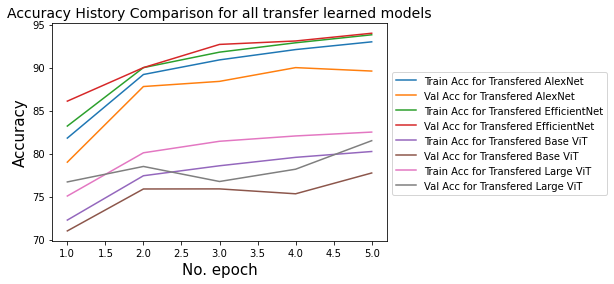

In [4]:
# Plot history: Accuracy
history_alex_train = [81.8, 89.2, 90.9, 92.1, 93.0]
history_alex_val = [79.0, 87.8, 88.4, 90.0, 89.6]

history_eff_train = [83.2, 90.0, 91.8, 92.89, 93.82]
history_eff_val = [86.1, 90.0, 92.7, 93.1, 94.0]

history_vit_b_train = [72.26, 77.42, 78.58, 79.56, 80.24]
history_vit_b_val = [71.0,75.88, 75.89, 75.32, 77.74]

history_vit_l_train = [75.06, 80.09, 81.43, 82.05, 82.50]
history_vit_l_val = [76.7, 78.5, 76.75, 78.18, 81.498]

epochs = [1, 2, 3, 4, 5]

plt.plot(epochs, history_alex_train, label='Train Acc for Transfered AlexNet')
plt.plot(epochs, history_alex_val, label='Val Acc for Transfered AlexNet')

plt.plot(epochs, history_eff_train, label='Train Acc for Transfered EfficientNet')
plt.plot(epochs, history_eff_val, label='Val Acc for Transfered EfficientNet')

plt.plot(epochs, history_vit_b_train, label='Train Acc for Transfered Base ViT')
plt.plot(epochs, history_vit_b_val, label='Val Acc for Transfered Base ViT')

plt.plot(epochs, history_vit_l_train, label='Train Acc for Transfered Large ViT')
plt.plot(epochs, history_vit_l_val, label='Val Acc for Transfered Large ViT')

plt.title('Accuracy History Comparison for all transfer learned models', fontsize=14)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('No. epoch', fontsize=15)
plt.legend(bbox_to_anchor=(1,0.8))
plt.show()

# Run First

In [5]:
def get_transform(model_name):

    if model_name == 'alexnet':
        transform = A.Compose([
            A.Resize(227, 227),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ToTensorV2(),
        ])

    elif model_name == 'effinet':
        transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ToTensorV2(),
        ])
        
    elif model_name == 'TransferViT':
        
        transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ToTensorV2(),
        ])
    
    return transform

In [6]:
class SurgicalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=False):
        super(SurgicalDataset, self).__init__()
        self.image_paths = image_paths
        self.labels = labels    #.astype(dtype='int')
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        label = self.labels[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [7]:
# Preparing the datasets
# Get images
train_image_paths = []
train_data_path = r"C:\Users\panji\EECS6691_Advanced_DL\Assignment2\training_data_images"
train_image_paths.append(glob.glob(train_data_path + '/*'))
# unpack the listed list
train_image_paths1 = [item for sublist in train_image_paths for item in sublist]
train_image_paths1 = natsort.natsorted(train_image_paths1)
print('len(train_image_paths1)', len(train_image_paths1))

# Get labels
df = pd.read_csv("Processed_data.csv")
df1 = df.loc[:,"Phases"].to_numpy()
df2 = df1.tolist()
print('len(df2)', len(df2))

# Preparing the datasets (images and labels)
dataset_train = pd.DataFrame(
    {'Link': train_image_paths1,
     'Label': df2,
    })
dataset_train1 = dataset_train.sample(frac=1, random_state=1)
train_image_paths = dataset_train1.loc[:,"Link"].to_numpy().tolist()
labels = dataset_train1.loc[:,"Label"].to_numpy().tolist()

# manually split the dataset
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]  
train_labels, valid_labels = labels[:int(0.8*len(labels))], labels[int(0.8*len(labels)):] 
print('train_labels', len(train_labels))
print('train_image_paths', len(train_image_paths))
print('label distribution in the training data', np.bincount(train_labels))

len(train_image_paths1) 215057
len(df2) 215057
train_labels 172045
train_image_paths 172045
label distribution in the training data [  243  8681 22901 41140   952 22305   666 10930   896  2308 44928 12987
  1789  1246    73]


In [8]:
class TransferViT_l_32(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = models.vit_l_32(pretrained=True)
        #self.conv_layer = self.get_conv_proj()
        self.vit.heads = self.get_fc_layers()
        #self.vit = self.get_ViT_encoder()
        #self.fc_model = self.get_fc_layers()
        self.activate_training_layers()

    def activate_training_layers(self):
#         for name, param in self.conv_layer.named_parameters():
#             # for all of these layers set param.requires_grad as True
#             param.requires_grad = False

        for name, param in self.vit.named_parameters():
            number = name.split('.')
            # for all layers except the last conv layer, set param.requires_grad = False
            if number[0] == 'heads':
#                 if number[1].split('_')[2] == 11 and number[2] == 'mlp':
#                     param.requires_grad = True
#                 else:
                param.requires_grad = True
                print('required_grad = True', number)
            else:
                param.requires_grad = False
                print('required_grad = False', number)
                
        #for name, param in self.vit.heads.named_parameters():
            # for all of these layers set param.requires_grad as True

    def get_fc_layers(self):
        return nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=15, bias=True),
        )
    
    def forward(self, x):
        #x = self.conv_layer(x)
        x = self.vit(x)
        #x = torch.flatten(x, 1)
        #x = self.fc_model(x)  #call fully connected layers  
        
        return x
    

class TransferViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = models.vit_b_32(pretrained=True)
        #self.conv_layer = self.get_conv_proj()
        self.vit.heads = self.get_fc_layers()
        #self.vit = self.get_ViT_encoder()
        #self.fc_model = self.get_fc_layers()
        self.activate_training_layers()

    def activate_training_layers(self):
#         for name, param in self.conv_layer.named_parameters():
#             # for all of these layers set param.requires_grad as True
#             param.requires_grad = False

        for name, param in self.vit.named_parameters():
            number = name.split('.')
            # for all layers except the last conv layer, set param.requires_grad = False
            if number[0] == 'heads':
#                 if number[1].split('_')[2] == 11 and number[2] == 'mlp':
#                     param.requires_grad = True
#                 else:
                param.requires_grad = True
                print('required_grad = True', number)
            else:
                param.requires_grad = False
                print('required_grad = False', number)
                
        #for name, param in self.vit.heads.named_parameters():
            # for all of these layers set param.requires_grad as True
           
    def get_fc_layers(self):
        return nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=768, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=15, bias=True),
        )
    
    def forward(self, x):
        #x = self.conv_layer(x)
        x = self.vit(x)
        #x = torch.flatten(x, 1)
        #x = self.fc_model(x)  #call fully connected layers  
        
        return x
    
    
class TransferEffiNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_effi_net = models.efficientnet_b7(pretrained=True)
        self.conv_model = self.get_conv_layers()
        self.avg_pool = self.transition_layer()
        self.fc_model = self.get_fc_layers()
        self.activate_training_layers()

    def activate_training_layers(self):
        for name, param in self.conv_model.named_parameters():
            number = int(name.split('.')[1])
            # for all layers except the last conv layer, set param.requires_grad = False
            if number == 8:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        for name, param in self.fc_model.named_parameters():
            # for all of these layers set param.requires_grad as True
            param.requires_grad = True

    def get_conv_layers(self):
        return self.base_effi_net.features

    def transition_layer(self):
        return self.base_effi_net.avgpool

    def get_fc_layers(self):
        return nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=2560, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=15, bias=True),
        )
    
    def forward(self, x):
        x = self.conv_model(x)   #call the conv layers
        x = self.avg_pool(x)  #call the avg pool layer
        x = torch.flatten(x, 1)
        x = self.fc_model(x)  #call fully connected layers  
        
        return x
    
    
class TransferAlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_alex_net = models.alexnet(pretrained=True)
        self.conv_model = self.get_conv_layers()
        self.final_max_pool = self.final_pool_layer()
        self.avg_pool = self.transition_layer()
        self.fc_model = self.get_fc_layers()
        self.activate_training_layers()

    def activate_training_layers(self):
        for name, param in self.conv_model.named_parameters():
            number = int(name.split('.')[0])
            # for all layers except the last layer set param.requires_grad = False
            if number < 10:
                param.requires_grad = False
            else:
                param.requires_grad = True
                
        for name, param in self.fc_model.named_parameters():
            # for all of these layers set param.requires_grad as True
            param.requires_grad = True

    def get_conv_layers(self):
        return self.base_alex_net.features[:12]

    def final_pool_layer(self):
        return nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)

    def transition_layer(self):
        return nn.AdaptiveAvgPool2d(output_size=(6, 6))

    def get_fc_layers(self):
        return nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=1000, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1000, out_features=15, bias=True),
        )
    
    def forward(self, x):
        x = self.conv_model(x)   #call the conv layers
        x = self.final_max_pool(x)  #call the max pool layer
        x = self.avg_pool(x)  #call the avg pool layer
        x = torch.flatten(x, 1)
        x = self.fc_model(x)  #call fully connected layers  
        
        return x

In [13]:
def get_pred(model, train_transforms, batch_size, use_cuda=True):
    val_dataset = SurgicalDataset(valid_image_paths, valid_labels, train_transforms)
    valid_loader = DataLoader(val_dataset, batch_size, shuffle = False)
    model = model.to('cuda' if use_cuda else 'cpu')
    pr = []
    pred = []
    l = []
    # again no gradients needed
    t = time.time()
    negative_examples = []
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            l.append(labels)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            m = F.softmax(outputs, dim=1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                pred.append(prediction)
            for p in m:
                pr.append(p)
                
    processtime = time.time()-t
    print('processtime', processtime)
    return l, pred, pr, processtime


In [37]:
def get_to_cpu(l, pred, pr):
    for i in range(len(l)):
        l[i] = l[i].cpu()
    for i in range(len(l)):
        l[i] = l[i].data.numpy()
    l = [item for sublist in l for item in sublist]
    for i in range(len(l)):
        pred[i] = pred[i].cpu().data.numpy()
    for i in range(len(l)):
        pr[i] = pr[i].cpu().data.numpy()
    return l, pred, pr

def get_class_names(y_true, y_predicted, classes):
    yt = [classes[i] for i in y_true]
    yp = [classes[i] for i in y_predicted]
    return yt, yp
    

# Data Gathering for the transfered AlexNet

In [23]:
# for validation set only
classes = ['Adhesiolysis', 'Peritoneal scoring', 'Preperitoneal dissection', 'Reduction of hernia', 'Mesh Positioning', 'Mesh Placement', 'Positioning of Suture', 'Positioning Suture', 'Direct hernia repair', 
          'Catherter Insertion', 'Peritoneal Closure', 'Transitory Idle', 'Statioanry Idle', 'Out of Body', 'Blurry']
# correct_predictions = {0: 49, 1: 2117, 2: 5491, 3: 9229, 4: 163, 5: 5288, 6: 136, 7: 2370, 8: 243, 9: 561, 10: 10284, 11: 1953, 12: 399, 13: 281, 14: 17}
# total_predictions =  {0: 52, 1: 2177, 2: 5799, 3: 10405, 4: 213, 5: 5470, 6: 158, 7: 2843, 8: 247, 9: 587, 10: 11135, 11: 3216, 12: 404, 13: 288, 14: 18}
# correct = [correct_predictions[i] for i in correct_predictions]
# total = [total_predictions[i] for i in total_predictions]
save_path = os.path.join(os.getcwd(), 'models', 'TransferAlexNet')
best_alex = TransferAlexNet()
best_alex.load_state_dict(torch.load(os.path.join(save_path, 'best.pt')))
transforms = get_transform('alexnet')
batch_size = 32
y_test_true, y_test_predicted, pr, time = get_pred(best_alex, transforms, batch_size)
y_test_true, y_test_predicted, pr = get_to_cpu(y_test_true, y_test_predicted, pr)
y_true, y_predicted = get_class_names(y_test_true, y_test_predicted, classes)

processtime 304.6354877948761


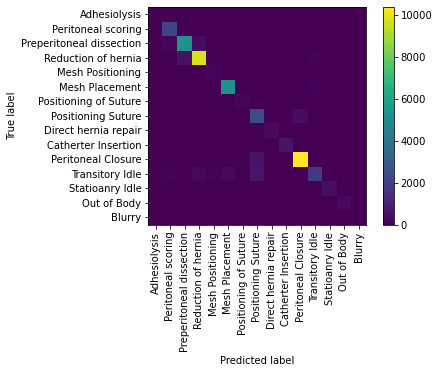

In [44]:
cm = confusion_matrix(y_true, y_predicted, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(include_values=False, xticks_rotation = 'vertical')
plt.show()

{'Adhesiolysis': {'precision': 0.94, 'recall': 0.9038461538461539, 'f1-score': 0.9215686274509804, 'support': 52}, 'Peritoneal scoring': {'precision': 0.8780183180682765, 'recall': 0.9687643546164446, 'f1-score': 0.9211618257261411, 'support': 2177}, 'Preperitoneal dissection': {'precision': 0.9012809564474807, 'recall': 0.9099844800827729, 'f1-score': 0.9056118071048567, 'support': 5799}, 'Reduction of hernia': {'precision': 0.9438691570695829, 'recall': 0.9373378183565594, 'f1-score': 0.9405921496769215, 'support': 10405}, 'Mesh Positioning': {'precision': 0.5224719101123596, 'recall': 0.8732394366197183, 'f1-score': 0.6537785588752197, 'support': 213}, 'Mesh Placement': {'precision': 0.9361473797174029, 'recall': 0.956855575868373, 'f1-score': 0.9463882108308471, 'support': 5470}, 'Positioning of Suture': {'precision': 0.6327433628318584, 'recall': 0.9050632911392406, 'f1-score': 0.7447916666666667, 'support': 158}, 'Positioning Suture': {'precision': 0.6543816543816544, 'recall': 0

<AxesSubplot:>

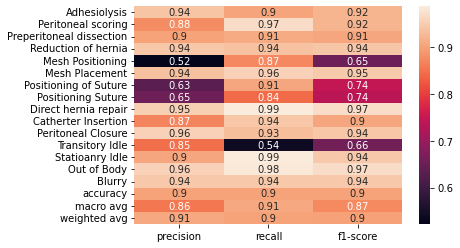

In [48]:
target_names = classes
c_report = classification_report(y_true, y_predicted, labels=classes, target_names=target_names, output_dict=True)
print(c_report)
basic_report = classification_report(y_true, y_predicted, labels=classes)
print(basic_report)
sns.heatmap(pd.DataFrame(c_report).iloc[:-1, :].T, annot=True)

In [49]:
print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovr'))
print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovo'))             

0.991774780210564
0.993675663933648


# Data Gathering for the transfered EfficientNet

In [50]:
correct_predictions = {0: 51, 1: 2094, 2: 5631, 3: 9911, 4: 176, 5: 5285, 6: 145, 7: 2457, 8: 245, 9: 567, 10: 10674, 11: 2494, 12: 400, 13: 286, 14: 17}
total_predictions = {0: 52, 1: 2177, 2: 5799, 3: 10405, 4: 213, 5: 5470, 6: 158, 7: 2843, 8: 247, 9: 587, 10: 11135, 11: 3216, 12: 404, 13: 288, 14: 18}

In [51]:
# for validation set only
classes = ['Adhesiolysis', 'Peritoneal scoring', 'Preperitoneal dissection', 'Reduction of hernia', 'Mesh Positioning', 'Mesh Placement', 'Positioning of Suture', 'Positioning Suture', 'Direct hernia repair', 
          'Catherter Insertion', 'Peritoneal Closure', 'Transitory Idle', 'Statioanry Idle', 'Out of Body', 'Blurry']
# correct_predictions = {0: 49, 1: 2117, 2: 5491, 3: 9229, 4: 163, 5: 5288, 6: 136, 7: 2370, 8: 243, 9: 561, 10: 10284, 11: 1953, 12: 399, 13: 281, 14: 17}
# total_predictions =  {0: 52, 1: 2177, 2: 5799, 3: 10405, 4: 213, 5: 5470, 6: 158, 7: 2843, 8: 247, 9: 587, 10: 11135, 11: 3216, 12: 404, 13: 288, 14: 18}
# correct = [correct_predictions[i] for i in correct_predictions]
# total = [total_predictions[i] for i in total_predictions]
save_path = os.path.join(os.getcwd(), 'models', 'TransferEffiNet')
best_effi = TransferEffiNet()
best_effi.load_state_dict(torch.load(os.path.join(save_path, 'best.pt')))
transforms = get_transform('effinet')
batch_size = 32
y_test_true, y_test_predicted, pr, time = get_pred(best_effi, transforms, batch_size)
y_test_true, y_test_predicted, pr = get_to_cpu(y_test_true, y_test_predicted, pr)    

processtime 351.8050129413605


TypeError: 'set' object is not subscriptable

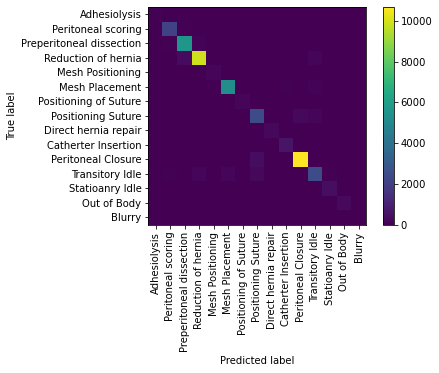

{'Adhesiolysis': {'precision': 0.8947368421052632, 'recall': 0.9807692307692307, 'f1-score': 0.9357798165137614, 'support': 52}, 'Peritoneal scoring': {'precision': 0.9509536784741145, 'recall': 0.9618741387230133, 'f1-score': 0.9563827357844258, 'support': 2177}, 'Preperitoneal dissection': {'precision': 0.9339857356112125, 'recall': 0.9710294878427315, 'f1-score': 0.9521474467365573, 'support': 5799}, 'Reduction of hernia': {'precision': 0.975588148439807, 'recall': 0.9525228255646324, 'f1-score': 0.9639175257731958, 'support': 10405}, 'Mesh Positioning': {'precision': 0.7586206896551724, 'recall': 0.8262910798122066, 'f1-score': 0.7910112359550561, 'support': 213}, 'Mesh Placement': {'precision': 0.9681260304084998, 'recall': 0.9661791590493601, 'f1-score': 0.9671516149693477, 'support': 5470}, 'Positioning of Suture': {'precision': 0.8011049723756906, 'recall': 0.9177215189873418, 'f1-score': 0.855457227138643, 'support': 158}, 'Positioning Suture': {'precision': 0.7974683544303798

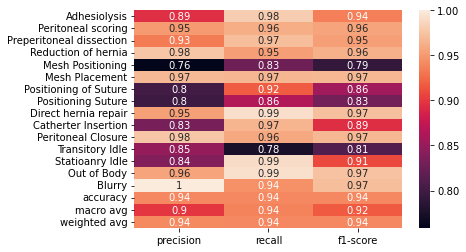

In [55]:
y_true, y_predicted = get_class_names(y_test_true, y_test_predicted, classes)
cm = confusion_matrix(y_true, y_predicted, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(include_values=False, xticks_rotation = 'vertical')
plt.show()

target_names = classes
c_report = classification_report(y_true, y_predicted, labels=classes, target_names=target_names, output_dict=True)
print(c_report)
basic_report = classification_report(y_true, y_predicted, labels=classes)
print(basic_report)
sns.heatmap(pd.DataFrame(c_report).iloc[:-1, :].T, annot=True)

print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovr'))
print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovo')) 

# Data Gathering for the transfered ViT base model

In [ ]:
correct_predictions = {0: 51, 1: 2044, 2: 3659, 3: 9166, 4: 186, 5: 4695, 6: 131, 7: 1904, 8: 244, 9: 530, 10: 8993, 11: 1135, 12: 399, 13: 284, 14: 17}
total_predictions = {0: 52, 1: 2177, 2: 5799, 3: 10405, 4: 213, 5: 5470, 6: 158, 7: 2843, 8: 247, 9: 587, 10: 11135, 11: 3216, 12: 404, 13: 288, 14: 18}

required_grad = False ['class_token']
required_grad = False ['conv_proj', 'weight']
required_grad = False ['conv_proj', 'bias']
required_grad = False ['encoder', 'pos_embedding']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'ln_1', 'weight']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'ln_1', 'bias']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'self_attention', 'in_proj_weight']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'self_attention', 'in_proj_bias']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'self_attention', 'out_proj', 'weight']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'self_attention', 'out_proj', 'bias']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'ln_2', 'weight']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'ln_2', 'bias']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'mlp', 'linear_1', 'weight']
required_

processtime 322.493004322052


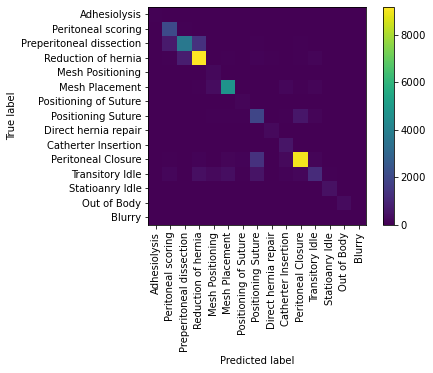

{'Adhesiolysis': {'precision': 0.6710526315789473, 'recall': 0.9807692307692307, 'f1-score': 0.7968749999999999, 'support': 52}, 'Peritoneal scoring': {'precision': 0.6774941995359629, 'recall': 0.9389067524115756, 'f1-score': 0.7870619946091645, 'support': 2177}, 'Preperitoneal dissection': {'precision': 0.8127498889382496, 'recall': 0.630970857044318, 'f1-score': 0.71041646442093, 'support': 5799}, 'Reduction of hernia': {'precision': 0.8286773347798572, 'recall': 0.8809226333493513, 'f1-score': 0.8540016770707164, 'support': 10405}, 'Mesh Positioning': {'precision': 0.21064552661381652, 'recall': 0.8732394366197183, 'f1-score': 0.3394160583941606, 'support': 213}, 'Mesh Placement': {'precision': 0.8838478915662651, 'recall': 0.8583180987202925, 'f1-score': 0.8708959376739009, 'support': 5470}, 'Positioning of Suture': {'precision': 0.35405405405405405, 'recall': 0.8291139240506329, 'f1-score': 0.4962121212121212, 'support': 158}, 'Positioning Suture': {'precision': 0.484601679816747

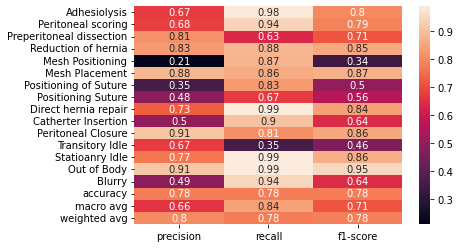

In [58]:
# for validation set only
import time
classes = ['Adhesiolysis', 'Peritoneal scoring', 'Preperitoneal dissection', 'Reduction of hernia', 'Mesh Positioning', 'Mesh Placement', 'Positioning of Suture', 'Positioning Suture', 'Direct hernia repair', 
          'Catherter Insertion', 'Peritoneal Closure', 'Transitory Idle', 'Statioanry Idle', 'Out of Body', 'Blurry']
# correct_predictions = {0: 49, 1: 2117, 2: 5491, 3: 9229, 4: 163, 5: 5288, 6: 136, 7: 2370, 8: 243, 9: 561, 10: 10284, 11: 1953, 12: 399, 13: 281, 14: 17}
# total_predictions =  {0: 52, 1: 2177, 2: 5799, 3: 10405, 4: 213, 5: 5470, 6: 158, 7: 2843, 8: 247, 9: 587, 10: 11135, 11: 3216, 12: 404, 13: 288, 14: 18}
# correct = [correct_predictions[i] for i in correct_predictions]
# total = [total_predictions[i] for i in total_predictions]
save_path = os.path.join(os.getcwd(), 'models', 'TransferViT')
best_vitb = TransferViT()
best_vitb.load_state_dict(torch.load(os.path.join(save_path, 'best.pt')))
transforms = get_transform('TransferViT')
batch_size = 32
y_test_true, y_test_predicted, pr, time = get_pred(best_vitb, transforms, batch_size)
y_test_true, y_test_predicted, pr = get_to_cpu(y_test_true, y_test_predicted, pr)
y_true, y_predicted = get_class_names(y_test_true, y_test_predicted, classes)

cm = confusion_matrix(y_true, y_predicted, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(include_values=False, xticks_rotation = 'vertical')
plt.show()

target_names = classes
c_report = classification_report(y_true, y_predicted, labels=classes, target_names=target_names, output_dict=True)
print(c_report)
basic_report = classification_report(y_true, y_predicted, labels=classes)
print(basic_report)
sns.heatmap(pd.DataFrame(c_report).iloc[:-1, :].T, annot=True)

print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovr'))
print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovo'))   

# Data Gathering for the transfered ViT large model

In [ ]:
correct_predictions = {0: 51, 1: 2032, 2: 3500, 3: 9769, 4: 186, 5: 4936, 6: 133, 7: 1903, 8: 245, 9: 527, 10: 9819, 11: 1256, 12: 398, 13: 282, 14: 17}
total_predictions = {0: 52, 1: 2177, 2: 5799, 3: 10405, 4: 213, 5: 5470, 6: 158, 7: 2843, 8: 247, 9: 587, 10: 11135, 11: 3216, 12: 404, 13: 288, 14: 18}

required_grad = False ['class_token']
required_grad = False ['conv_proj', 'weight']
required_grad = False ['conv_proj', 'bias']
required_grad = False ['encoder', 'pos_embedding']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'ln_1', 'weight']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'ln_1', 'bias']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'self_attention', 'in_proj_weight']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'self_attention', 'in_proj_bias']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'self_attention', 'out_proj', 'weight']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'self_attention', 'out_proj', 'bias']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'ln_2', 'weight']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'ln_2', 'bias']
required_grad = False ['encoder', 'layers', 'encoder_layer_0', 'mlp', 'linear_1', 'weight']
required_

processtime 342.0810308456421


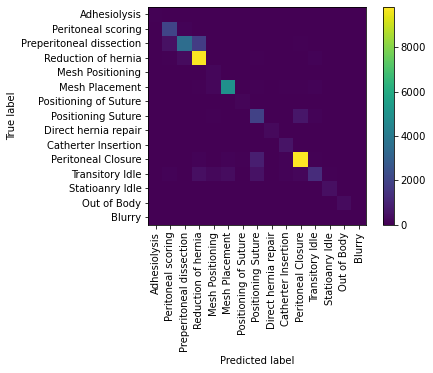

{'Adhesiolysis': {'precision': 0.6219512195121951, 'recall': 0.9807692307692307, 'f1-score': 0.7611940298507464, 'support': 52}, 'Peritoneal scoring': {'precision': 0.7542687453600594, 'recall': 0.9333945796968305, 'f1-score': 0.8343256004927119, 'support': 2177}, 'Preperitoneal dissection': {'precision': 0.8939974457215837, 'recall': 0.6035523366097603, 'f1-score': 0.7206094296891086, 'support': 5799}, 'Reduction of hernia': {'precision': 0.8045626750123538, 'recall': 0.9388755406054782, 'f1-score': 0.8665454384175278, 'support': 10405}, 'Mesh Positioning': {'precision': 0.28440366972477066, 'recall': 0.8732394366197183, 'f1-score': 0.4290657439446367, 'support': 213}, 'Mesh Placement': {'precision': 0.9041949074922147, 'recall': 0.9023765996343693, 'f1-score': 0.9032848385030653, 'support': 5470}, 'Positioning of Suture': {'precision': 0.4907749077490775, 'recall': 0.8417721518987342, 'f1-score': 0.62004662004662, 'support': 158}, 'Positioning Suture': {'precision': 0.567213114754098

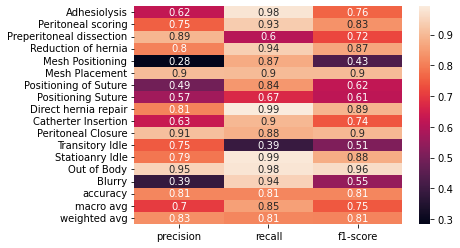

In [59]:
# for validation set only
import time
classes = ['Adhesiolysis', 'Peritoneal scoring', 'Preperitoneal dissection', 'Reduction of hernia', 'Mesh Positioning', 'Mesh Placement', 'Positioning of Suture', 'Positioning Suture', 'Direct hernia repair', 
          'Catherter Insertion', 'Peritoneal Closure', 'Transitory Idle', 'Statioanry Idle', 'Out of Body', 'Blurry']
# correct_predictions = {0: 49, 1: 2117, 2: 5491, 3: 9229, 4: 163, 5: 5288, 6: 136, 7: 2370, 8: 243, 9: 561, 10: 10284, 11: 1953, 12: 399, 13: 281, 14: 17}
# total_predictions =  {0: 52, 1: 2177, 2: 5799, 3: 10405, 4: 213, 5: 5470, 6: 158, 7: 2843, 8: 247, 9: 587, 10: 11135, 11: 3216, 12: 404, 13: 288, 14: 18}
# correct = [correct_predictions[i] for i in correct_predictions]
# total = [total_predictions[i] for i in total_predictions]
save_path = os.path.join(os.getcwd(), 'models', 'TransferViT_l_32')
best_ViTL = TransferViT_l_32()
best_ViTL.load_state_dict(torch.load(os.path.join(save_path, 'best.pt')))
transforms = get_transform('TransferViT')
batch_size = 32
y_test_true, y_test_predicted, pr, time = get_pred(best_ViTL, transforms, batch_size)
y_test_true, y_test_predicted, pr = get_to_cpu(y_test_true, y_test_predicted, pr)
y_true, y_predicted = get_class_names(y_test_true, y_test_predicted, classes)

cm = confusion_matrix(y_true, y_predicted, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(include_values=False, xticks_rotation = 'vertical')
plt.show()

target_names = classes
c_report = classification_report(y_true, y_predicted, labels=classes, target_names=target_names, output_dict=True)
print(c_report)
basic_report = classification_report(y_true, y_predicted, labels=classes)
print(basic_report)
sns.heatmap(pd.DataFrame(c_report).iloc[:-1, :].T, annot=True)

print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovr'))
print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovo'))   